In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

# from testsuite.utilities import Pareto_split
from testsuite.analysis import load_all #, plot_all_pareto_2d, PLOT_STYLE, plot_measure
from problem_setup import func, y, weighting, n_obj, n_dim

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 11

In [3]:
## establish up data paths
results_dir = "./log_data/"
result_dirs = sorted(os.listdir("./log_data/"))

pkl_dir = "./pkl_data/"
pkl_filename = pkl_dir+'results.pkl'
if not os.path.isdir(pkl_dir):
    os.makedirs(pkl_dir)

In [4]:
try:
    with open(pkl_filename,'rb') as infile:
        results = pickle.load(infile)
    print("results loaded from ", pkl_dir)
except FileNotFoundError:
    print("Failed to find results file in {}".format(pkl_filename))
    print("Results processing should be done first by running results_processing.py")
    
try:
    assert len(results) == 7
    for result in results:
        assert len(result['log_dir']) ==31
        print(result['name'])
    print("\n All results present.")
except:
    print("not all results present")
    for result in results:
        print(result['name'], "\t", "({}\{})".format(len(result['log_dir']), 31))

results loaded from  ./pkl_data/
Mpoi
ParEgo
Saf ei
Saf $\mu$
SmsEgo ei
SmsEgo $\mu$
LHS

 All results present.


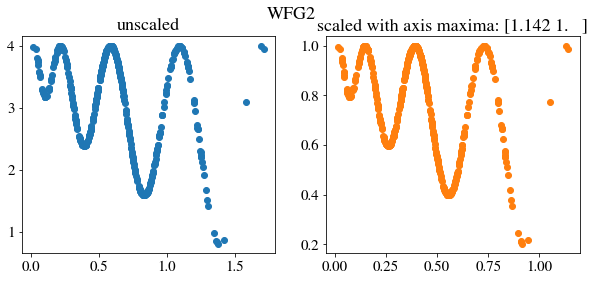

In [5]:
fig = plt.figure(figsize=[10, 4])
if n_obj > 4:
    print("cannot plot more objectives than 3")
else:
    if n_obj == 2:
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)
    elif n_obj == 3:
        ax1=fig.add_subplot(1,2,1, projection="3d")
        ax2=fig.add_subplot(1,2,2, projection="3d")
    ax1.scatter(*y.T)
    ax2.scatter(*(y/weighting).T, c="C1")
    plt.suptitle(func.__name__)
    ax1.set_title("unscaled")
    ax2.set_title("scaled with axis maxima: {}".format((y/weighting).max(axis=0).round(3)))
    
    plt.show(block=True)

In [6]:
markers = ["o", "d", "^", "P", "X", "v", "*"]
cmap = matplotlib.cm.tab10
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

In [7]:
def plot_measure(results, measure, axis=None, plot_individuals=False, 
                     color="C0", marker=None): 
    label = results['name']
    if axis is None: 
        fig = plt.figure(figsize=[12, 8]) 
        axis = fig.gca() 
 
    hvs = results[measure] 
    if plot_individuals: 
        for i, hv in enumerate(hvs): 
            # plot idividual results 
            n_inital = results["n_initial"][i] 
            n_total = results["n_evaluations"][i] 
            bo_steps = range(n_inital, n_total + 1) 
            axis.plot(bo_steps, hv, linestyle=":", c=color, alpha=0.4) 
 
    # trim hvs to min length so as to compute mean 
    array_hvs = np.array([hv[:min([len(hv) for hv in hvs])] for hv in hvs]) 
    n_inital = results["n_initial"][0] 
    bo_steps = range(n_inital, array_hvs.shape[1]+n_inital) 
    
    # plot median and iqr
    axis.plot(bo_steps, np.median(array_hvs, axis=0), linestyle="-", c=color, 
              alpha=1., label=label, marker = marker, markevery=10) 
    lower_qa = np.array([np.quantile(i, 0.25) for i in np.array(array_hvs).T]) 
    upper_qa = np.array([np.quantile(i, 0.75) for i in np.array(array_hvs).T]) 
    axis.fill_between(bo_steps, 
                      lower_qa, 
                      upper_qa, 
                      color=color, alpha=0.2) 
 
    if axis is None: 
        return fig 

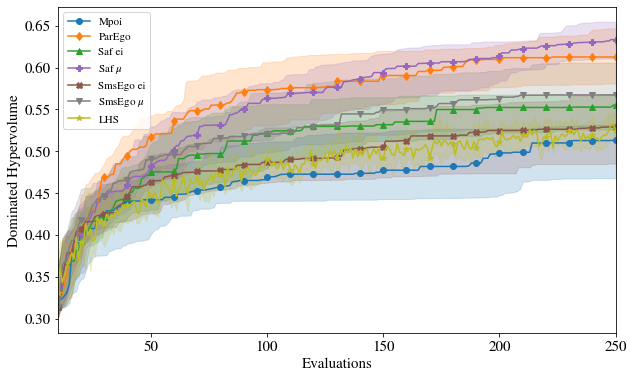

In [8]:
fig_hv = plt.figure(figsize=[10, 6])
ax_hv = fig_hv.gca()
for result, color, marker,in zip(results, colors, markers):
    plot_measure(result, measure="hpv", axis=ax_hv, plot_individuals=False, color=color, marker=marker)
ax_hv.set_xlim([10, 250])
ax_hv.set_xlabel("Evaluations")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

Text(0.5, 1.0, '250 Steps')

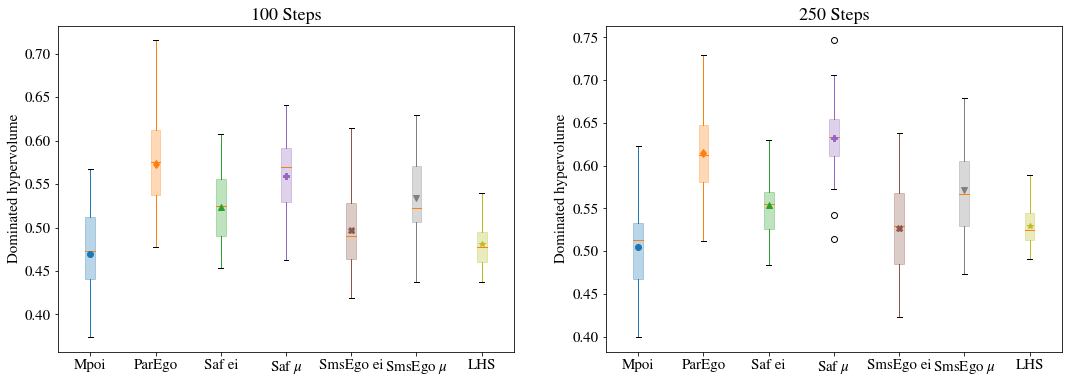

In [9]:
fig_hv_100 = plt.figure(figsize=[18, 6])
ax_hv_100 = fig_hv_100.add_subplot(1,2,1)
ax_hv_250 = fig_hv_100.add_subplot(1,2,2)

for i, result in enumerate(results):
    boxprops= {'color':colors[i], 'facecolor':colors[i], 'alpha':0.3}
    whiskerprops= {'color':colors[i]}
    meanprops = {"marker": markers[i], 'markerfacecolor': colors[i], 'markeredgecolor': colors[i]}
    ax_hv_100.boxplot([hpv[100] for hpv in result["hpv"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=True)
    ax_hv_250.boxplot([hpv[-1] for hpv in result["hpv"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=True)

ax_hv_100.set_ylabel('Dominated hypervolume')
ax_hv_100.set_title('100 Steps')
ax_hv_250.set_ylabel('Dominated hypervolume')
ax_hv_250.set_title('250 Steps')

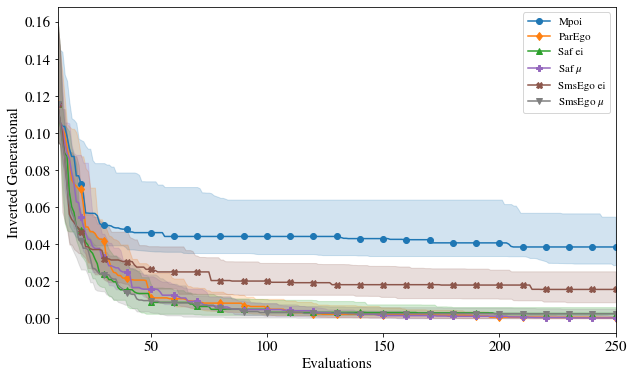

In [10]:
fig_igd = plt.figure(figsize=[10, 6])
ax_igd = fig_igd.gca()
for result, color, marker,in zip(results, colors, markers):
    if result['name'] != 'LHS':
        plot_measure(result, measure="igd+", axis=ax_igd, plot_individuals=False, color=color, marker=marker)
ax_igd.set_xlim([10, 250])
ax_igd.set_xlabel("Evaluations")
ax_igd.set_ylabel("Inverted Generational ")
ax_igd.legend()

Text(0.5, 1.0, '250 Steps')

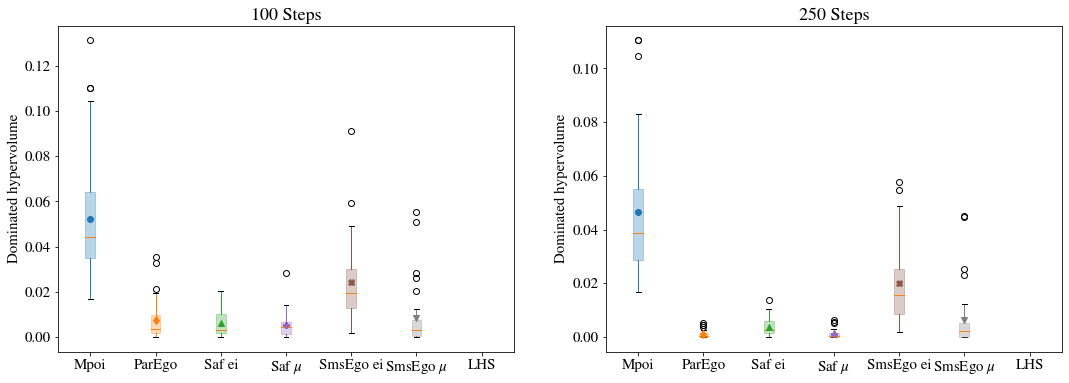

In [11]:
fig_igd_100 = plt.figure(figsize=[18, 6])
ax_igd_100 = fig_igd_100.add_subplot(1,2,1)
ax_igd_250 = fig_igd_100.add_subplot(1,2,2)

for i, result in enumerate(results):
    boxprops= {'color':colors[i], 'facecolor':colors[i], 'alpha':0.3}
    whiskerprops= {'color':colors[i]}
    meanprops = {"marker": markers[i], 'markerfacecolor': colors[i], 'markeredgecolor': colors[i]}
    ax_igd_100.boxplot([hpv[100] for hpv in result["igd+"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=True)
    ax_igd_250.boxplot([hpv[-1] for hpv in result["igd+"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=True)

ax_igd_100.set_ylabel('Dominated hypervolume')
ax_igd_100.set_title('100 Steps')
ax_igd_250.set_ylabel('Dominated hypervolume')
ax_igd_250.set_title('250 Steps')

In [12]:
## hpv rankings
hpv_medians = np.zeros((len(results), np.shape(results[0]['hpv'][0])[0]))
for i, result in enumerate(results):
    hpv_medians[i] = np.median(result['hpv'], axis=0)
hpv_medians.shape
hpv_rank = np.argsort(np.argsort(-1*hpv_medians, axis=0), axis=0)+1

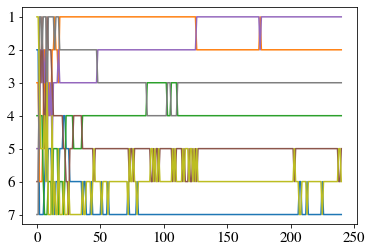

In [13]:
for i in range(7):
    plt.plot(range(241), hpv_rank[i], c=colors[i])
plt.gca().invert_yaxis()

In [14]:
## igd rankings
igd_medians = np.zeros((len(results), np.shape(results[0]['igd+'][0])[0]))
for i, result in enumerate(results):
    igd_medians[i] = np.median(result['igd+'], axis=0)
igd_rank = np.argsort(np.argsort(-1*igd_medians, axis=0), axis=0)+1
igd_rank *= -1
igd_rank += igd_rank.min()

/home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


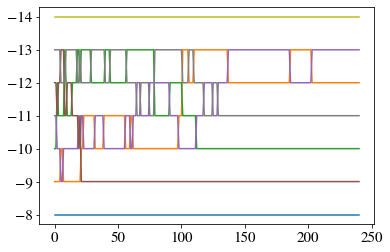

In [15]:
for i in range(7):
    plt.plot(range(241), igd_rank[i], c=colors[i])
plt.gca().invert_yaxis()

In [16]:
with open('./pkl_data/hpv_rank.pkl', 'wb') as outfile:
    pickle.dump(hpv_rank, outfile)
with open('./pkl_data/igd_rank.pkl', 'wb') as outfile:
    pickle.dump(igd_rank, outfile)